<a href="https://colab.research.google.com/github/axiom19/AI-Assistant-for-Personal-Documents/blob/main/Chatbot_for_personal_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ChatBot For Personal Data files With Retrieval Augmented Generation (RAG)

We will create a chatbot for our own pdf file using Flask, a popular web framework, and LangChain, another popular framework for working with large language models (LLMs). The chatbot you develop will not just interact with users through text but also comprehend and answer questions related to the content of a specific document.

### Chatbots
Chatbots are software applications designed to engage in human-like conversation. They can respond to text inputs from users and are widely used in various domains, including customer service, eCommerce, and education. In this project, you will build a chatbot capable of not only engaging users in a general conversation but also answering queries based on a particular document.
<br>

###LangChain
LangChain is a versatile tool for building AI-driven language applications. It provides various functionalities such as text retrieval, summarization, translation, and many more, by leveraging pretrained language models. In this project, you will be integrating LangChain into your chatbot, empowering it to understand and respond to diverse user inputs effectively.
<br>
###Flask
Flask is a lightweight and flexible web framework for Python, known for its simplicity and speed. A web framework is a software framework designed to support the development of web applications, including the creation of web servers, and management of HTTP requests and responses.

We will use Flask to create the server side or backend of your chatbot. This involves handling incoming messages from users, processing these messages, and sending appropriate responses back to the user.



>The diagram illustrates the procedure of document processing and information retrieval, seamlessly integrating a large language model (LLM) to facilitate the task of question answering.  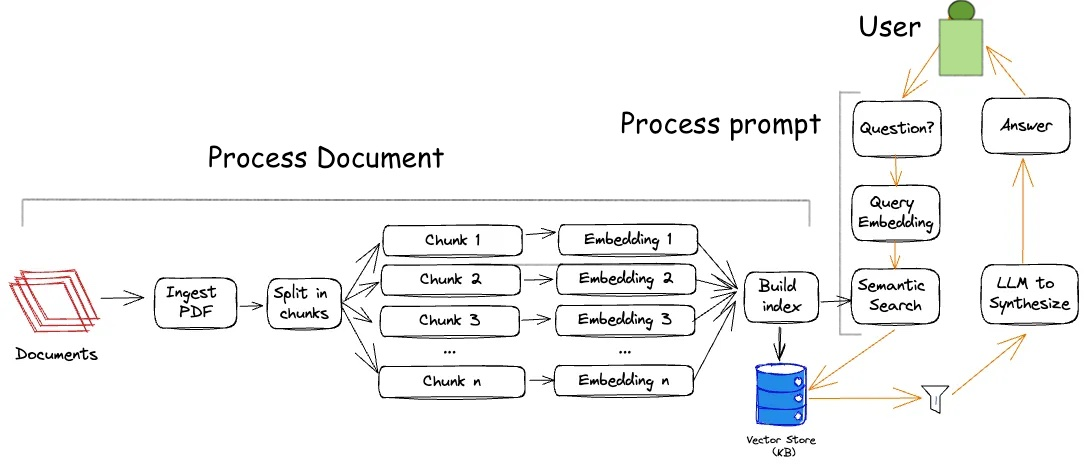



In [1]:
# ! pip install -r requirements.txt
# ! pip install gradio
# ! pip install -U langchain-community

### Import Statements

In [2]:
import os
import torch
from langchain import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.llms import HuggingFaceHub
import gradio as gr

## Step 1: Initalize LLM

In [3]:
# check for gpu
device = "cuda" if torch.cuda.is_available() else "cpu"

# declare global variables
chat_history = []
conversational_retrieval_chain = None
llm_hub = None
embeddings = None

In [8]:
# function to initialize the LLM and its embeddings

def llm_init():
    global llm_hub
    global embeddings

    # set up the env variable and initialize the LLM
    os.environ["HUGGINGFACEHUB_API_TOKEN"] = "API"

    model_id = "google/pegasus-xsum"
    model_kwargs = {"temperature": 0.2, "max_new_tokens": 800, "max_length": 800}

    llm_hub = HuggingFaceHub(
        repo_id=model_id,
        model_kwargs=model_kwargs,
    )

    # initialize the embeddings
    embeddings = HuggingFaceInstructEmbeddings(
        model_name="sentence-transformers/all-MiniLM-L6-v2",
        model_kwargs={"device": device},
    )

## Step 2: Process the Document

In [5]:
def process_document(document_path):
    global conversational_retrieval_chain

    # load the document
    loader = PyPDFLoader(document_path)
    document = loader.load()

    # split the document into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1024,
        chunk_overlap=64,
    )
    texts = text_splitter.split_documents(document)

    # create an embeddings database using Chroma from the split text chunks.
    db = Chroma.from_documents(
        texts,
        embeddings,
    )


    # create the QA chain, which utilizes the LLM and retriever for answering questions.
    # by default, the vectorstore retriever uses similarity search.
    # if the underlying vectorstore support maximum marginal relevance search, you can specify that as the search type (search_type="mmr").
    # you can also specify search kwargs like k to use when doing retrieval. k represent how many search results send to llm
    conversational_retrieval_chain = RetrievalQA.from_chain_type(
        llm=llm_hub,
        chain_type='stuff',
        retriever=db.as_retriever(search_kwargs={'k': 6, 'lambda_mult': 0.25}),
        return_source_documents=False,
        chain_type_kwargs={
            "prompt": PromptTemplate(
                input_variables=["context", "question"],
                template="Context: {context}\n\nQuestion: {question}\n\nAnswer:"
            )}
    )

## Step 3: Process User Prompt

In [6]:
def process_prompt(prompt):
    global conversational_retrieval_chain, chat_history

    # pass prompt and chat history to conversational retrieval chain
    output = conversational_retrieval_chain({"query": prompt, "chat_history":chat_history})
    answer = output["result"]

    # update the chat history
    chat_history.append((prompt, answer))

    return answer

In [9]:
# initalize the language model
llm_init()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


## Step 4: Create the User Interface

In [10]:
import gradio as gr

In [11]:
# create a file upload function

def upload_and_process_file(file):
    if file is not None:
        file_path = os.path.join("data", file.name)
        file.save(file_path)

        # process the file
        process_document(file_path)
        return "File uploaded and processed successfully!"

    return "No file uploaded."


# main gr function
def pdf_qa(file, question):
    if file:
        upload_result = upload_and_process_file(file)
        if "successfuly" not in upload_result:
            return upload_result

    if not question:
        return "Please enter a question."

    answer = process_prompt(question)
    return answer

In [14]:
iface = gr.Interface(
    fn=pdf_qa,
    inputs=[
        gr.File(label="Upload PDF", file_types=["pdf"]),
        gr.Textbox(label="Enter your question")
    ],
    outputs=[gr.Textbox(label="Answer")],
    title="Chatbot For Personal Data",
    description="Upload a PDF file and ask questions about its content.",
    allow_flagging="never"
)

In [15]:
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9b011f18b3db91a16f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
